# TC 3006B Inteligencia artificial avanzada para la ciencia de datos I
# CIFAR-10 Data Preparation (PyTorch)
## Feedback

## Deep Learning -- Data Cleaning

### Objective: Load CIFAR-10, explore data, compute per-channel statistics (mean & std), normalize images, and verify normalization.

### Instructions
- Focus on data preparation, analysis, data is not usually as nice as CIFAR10 is. Model training follows as explained in classes.
- Write comments and reflections in the indicated, verify you answer questions in Markdown cells.
- Keep your code clean, reproducible, and well‑commented.

### Equipo:
* Andrea Medina Rico | A01705541
* Diego Lira García | A01710369
* Ernesto Acosta Ruiz | A01364982
* Gabriela Chimali Nava Ramírez | A01710530
* Victor Adid Salgado Santana | A01710023





## Environment & Reproducibility


In [1]:
# Install libraries as needed, if using Colab, maybe all good

import os, json, random, math, time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

##########################################
SEED = 42 #for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
###########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
cpu



## Download & Load CIFAR-10 (Train/Test Splits)


#### If using Colab you may need the following

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/Datasets')

In [7]:
# Maybe obvious, adjust path according to your needs
DATA_DIR = Path("./data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Base transform for statistics: convert to tensor only (no normalization/augmentations yet)
base_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=base_transform)
test_set  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=base_transform)

print("Imágenes de entrenamiento:" ,len(train_set))
print("Imágenes de prueba: " ,len(test_set))
print("Dimensiones de las imágenes de entrenamiento: ", train_set.data.shape)
print("Dimensiones de las imágenes de prueba: ", test_set.data.shape)


100%|██████████| 170498071/170498071 [00:01<00:00, 96760549.31it/s] 
Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Imágenes de entrenamiento: 50000
Imágenes de prueba:  10000
Dimensiones de las imágenes de entrenamiento:  (50000, 32, 32, 3)
Dimensiones de las imágenes de prueba:  (10000, 32, 32, 3)



### Explore de dataset


In [10]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

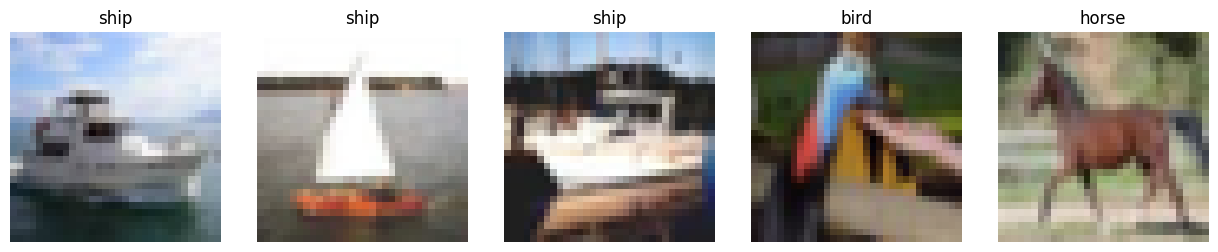

In [13]:
def show_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(n*2.5, 2.5))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        # img: tensor [C,H,W] in [0,1]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # HWC
        ax.set_title(classes[label])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train_set, n=5)



> **Reflection (Markdown):** Describe CIFAR‑10 (resolution, channels, number of classes/samples). Include one sentence on why normalization is helpful for training.


CIFAR-10 cuenta con 50,000 imágenes de entrenamiento y 10,000 imágenes de testeo. Las imágenes tienen dimensiones de 32 x 32 pixeles (ancho y alto) y 3 canales de color RGB. Por ello las dimensiones de los datos son (# de imagenes, pixeles altura, pixeles anchura, canales de color).

El dataset cuenta con 10 clases distintas, de las cuáles son especies de animales:
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse'
y medios de transporte:  
 'ship',
 'truck', 
 'airplane',
 'automobile',

La normalización es una técnica de preprocesamiento de datos que consiste en transformar las características del conjunto de datos a una escala estándar. Al tener una escala numérica similar, ninguna variable tiene valores más grandes y se evita que el modelo tienda a darle un mayor peso erróneo. Las relaciones entre categorías resultan más identificables y el modelo logra llegar a la convergencia de manera más óptima.


## Compute Per‑Channel Mean & Standard Deviation



In [16]:
BATCH_SIZE = 512
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
#mini batches de 512 imágenes
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([512, 3, 32, 32])
torch.Size([512])


El dataloader cambia la posición de las dimensiones, al ponerle un batch size de 512, entonces se irán seleccionando de 512 en 512 imágenes.

Las dimensiones del dataloader entonces corresponden a:
(#Imágenes, canales RGB, pixeles de altura, pixeles de anchura)

In [22]:
'''
Compute mean and std, before normalization

'''
# Nos interesa conservar la dimensión de los canales, por ello se deja intacta esa columna
#Se hace las operaciones con las demás para sacar la media y std por cada canal
def calc_mean_std(train_loader):
  for images, labels in train_loader:
    mean = images.mean((0,2,3))
    std = images.std((0,2,3))

  return mean, std

In [25]:
mean, std = calc_mean_std(train_loader)
print("Mean = ", mean)
print("Std = ", std)

Mean =  tensor([0.4991, 0.4921, 0.4611])
Std =  tensor([0.2500, 0.2453, 0.2643])



> Record your computed values here (e.g., `Mean ≈ [0.4914, 0.4822, 0.4465]`, `Std ≈ [0.2470, 0.2435, 0.2616]`). Your numbers should closely match these canonical references.


Mean =  tensor([0.4991, 0.4921, 0.4611])
Std =  tensor([0.2500, 0.2453, 0.2643])


## Normalize Datasets Using Computed Stats


In [28]:
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_set_norm = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=train_transform)
test_set_norm  = datasets.CIFAR10(root=DATA_DIR, train=False, download=False, transform=test_transform)

len(train_set_norm), len(test_set_norm)


(50000, 10000)


## Verify Normalization (Means ≈ 0, Stds ≈ 1)

Confirm the transformation worked as intended.


In [31]:

train_loader_norm = DataLoader(train_set_norm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

'''
Verify that data are normalized
'''

mean_norm, std_norm = calc_mean_std(train_loader_norm)
print("Mean = ", mean_norm)
print("Std = ", std_norm)


Mean =  tensor([ 1.3460e-07, -4.0224e-08, -3.5883e-07])
Std =  tensor([1., 1., 1.])



> Report the post‑normalization means and stds. They should be close to `[0,0,0]` and `[1,1,1]` (small deviations are normal due to rounding/batching).


Al calcular la media y desviación estándar del dataset de entrenamiento normalizado se puede corroborar que efectivamente la media es muy cercana a 0 y la desviación estándar es 1, para cada canal. 

Mean =  tensor([ 1.3460e-07, -4.0224e-08, -3.5883e-07])
Std =  tensor([1., 1., 1.])


## Light Data Augmentation
Add a few basic augmentations (random crop with padding, random horizontal flip). Use **train** only.


In [34]:

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #anything else you may want to add is welcomed
    normalize,
])

train_set_aug = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=aug_transform)
len(train_set_aug)


50000


> Explain when/why augmentation helps. What risks do heavy augmentations pose for small images like CIFAR‑10 (32×32)?

La augmentación es sumamente útil cuando el _dataset_ es limitado. La augmentación incrementa la efectividad del dataset al generar variaciones de las imágenes de entrenamiento crear transformaciones de estas al rotarlas, invertirlas, cortarlas, etc. Esto permite al modelo ser más robusto al poder interpretar imágenes que no sean claras. Otra ventaja es que mejora la generalización del modelo ya que este no memoria pequeños detalles y se enfoca en patrones pricipalmente. En práctica, las imágenes pueden aparecer en diferentes orientaciones, niveles de iluminación y/o posiciones, las augmentaciones simulan estas variaciones.

Los riesgos de usar augmentaciones en datasets de resoluciones pequeñas como lo es con CIFAR-10 son la perdida de información crítica ya que un pixel en estas imágenes contiene demasiada información y al modificarse esta se pierde. Otro riesgo es que el modelo puede aprender de estas distorciones y crear un modelo que tenga "underfitting". En resumen las augmentaciones en datasets con imágenes pequeñas puede ser útil si las transformaciones son mínimas para que no se pierda información crítica y el modelo pueda ajustarse de manera correcta a lo que las imágenes quieren respresentar.


## Class Distribution
Confirm class balance. CIFAR‑10 should be balanced across the 10 classes. Create a plot as a visual aid


Class Distribution:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


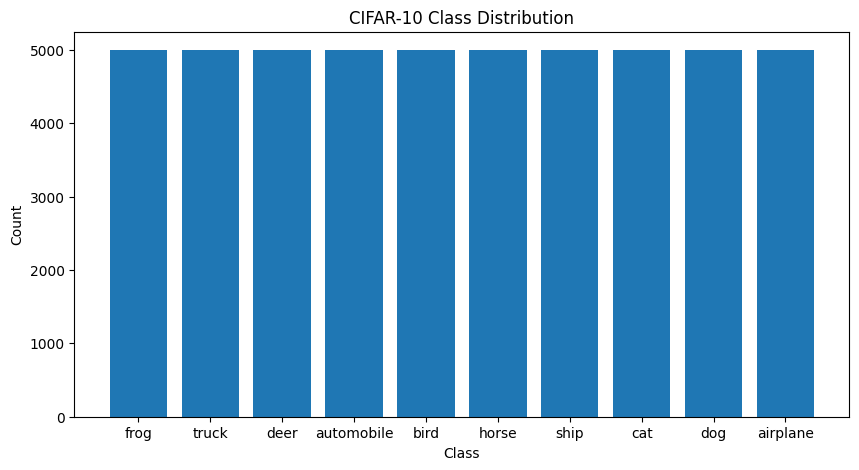

In [52]:
'''
Cifar10 is perfectly distributed among classes, this will not always be the case, plots help, numbers help
'''

# show class distribution
clases = train_set.classes
class_counts = {}
for _, label in train_set:
    if classes[label] not in class_counts:
        class_counts[classes[label]] = 0
    class_counts[classes[label]] += 1

print("Class Distribution:")
for clases, count in class_counts.items():
    print(f"{clases}: {count}")

# show plot
plt.figure(figsize = (10,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("CIFAR-10 Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Con base en los resultados verificamos que el dataset CIFAR-10 está perfectamente balanceado, con exactamente 5,000 imágenes en cada una de las 10 clases.


## 9. Submission Checklist
- [ ] Printed dataset sizes and showed random sample images.
- [ ] Reported per‑channel mean & std from the training set.
- [ ] Applied normalization using computed stats.
- [ ] Verified post‑normalization mean/std are ~0/1.
- [ ] Basic augmentations and rationale.


## 10. Referencias
- Jaiswal, S. (2024, 4 enero). What is normalization in machine learning? A comprehensive guide to data rescaling. Datacamp. https://www.datacamp.com/tutorial/normalization-in-machine-learning


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c5c0a52a-58b9-461a-b44d-428bf22537e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>